In [1]:
import sys
import subprocess
import importlib.util

required = ["pandas", "openpyxl", "scikit-learn", "numpy", "seaborn", "matplotlib"]
missing = [pkg for pkg in required if importlib.util.find_spec(pkg) is None]

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages already installed.")



Installing missing packages: ['scikit-learn']


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

DATA_PATH = "dataset.xlsx"

# Load and clean
raw = pd.read_excel(DATA_PATH)
# Normalize column names: remove NBSP and collapse whitespace
raw.columns = (raw.columns.str.replace(u"\xa0", " ", regex=False)
                         .str.replace(r"\s+", " ", regex=True)
                         .str.strip())

# Convert all non-ID columns to numeric (coerce errors to NaN)
non_id_cols = [c for c in raw.columns if c != "Patient ID"]
raw[non_id_cols] = raw[non_id_cols].apply(pd.to_numeric, errors="coerce")

if "Patient ID" not in raw.columns:
    raise KeyError("'Patient ID' column is required for deduplication.")

# Drop duplicate patients
clean = raw.drop_duplicates(subset=["Patient ID"]).copy()
feature_cols = [c for c in clean.columns if c != "Patient ID"]

# Patient filter: keep rows with at least 10 non-missing labs
patient_counts = clean[feature_cols].notna().sum(axis=1)
patient_filtered = clean[patient_counts >= 10].copy()

# Feature filter: keep features with <80% missingness in this subset
missing_frac = patient_filtered[feature_cols].isna().mean()
kept_features = missing_frac[missing_frac < 0.80].index.tolist()
final_cols = ["Patient ID"] + kept_features

filtered = patient_filtered[final_cols].copy()

print(f"Patients retained (>=10 labs): {filtered.shape[0]}")
print(f"Features retained (<80% missing): {len(kept_features)}")
print("Kept feature names:")
print(kept_features)



FileNotFoundError: [Errno 2] No such file or directory: 'dataset.xlsx'

In [ ]:
# Median imputation and z-score scaling
numeric_cols = [c for c in filtered.select_dtypes(include=[np.number]).columns if c != "Patient ID"]

if numeric_cols:
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    imputed = imputer.fit_transform(filtered[numeric_cols])
    scaled = scaler.fit_transform(imputed)

    df_scaled = pd.DataFrame(scaled, columns=numeric_cols, index=filtered.index)
    df_final = filtered.copy()
    df_final[numeric_cols] = df_scaled
else:
    df_final = filtered.copy()
    print("No numeric features found to impute/scale; returning filtered data.")

# Ensure all lab columns (excluding ID and SARS result) are numeric
lab_numeric_cols = [c for c in df_final.columns if c not in ["Patient ID", "SARS-Cov-2 exam result"]]
df_final[lab_numeric_cols] = df_final[lab_numeric_cols].apply(pd.to_numeric, errors="coerce")

print(f"Final dataframe shape (patients, features): {df_final.shape}")

if numeric_cols:
    print("Head of processed data:")
    display(df_final.head())

    summary = df_final[numeric_cols].agg(["mean", "std"]).T
    print("Scaled feature summary (mean ~0, std ~1):")
    display(summary)
else:
    print("Summary skipped: no numeric features.")



Final dataframe shape (patients, features): (603, 41)
Head of processed data:


,Patient ID,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Indirect Bilirubin,Alkaline phosphatase,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),International normalized ratio (INR)
1,126e9dd13932f68,1.025033,-0.329326,-0.273617,-0.224772,0.237807,-0.021514,-0.517634,0.011387,0.102066,...,-0.1491,-0.166821,0.006522,0.042782,0.038043,-0.099257,0.049226,-0.043023,0.047757,-0.072645
8,8bb9d64f0215244,-1.772568,-0.329326,3.654743,-0.224772,-1.571261,-0.773568,1.431039,-1.677063,-0.850764,...,-0.1491,-0.166821,1.273745,-1.311319,-0.726625,-0.824229,0.049226,-1.647957,-0.087761,0.882230
15,6c9d3323975b082,-0.373767,-0.329326,-0.273617,-0.224772,-0.746876,-0.585554,-0.429630,-0.213740,-1.362468,...,-0.1491,-0.166821,0.006522,0.042782,0.038043,-0.099257,0.049226,-0.043023,0.047757,0.166074
18,d3ea751f3db9de9,-0.024067,-0.329326,-0.273617,-0.224772,0.993493,0.793211,0.073254,-0.551429,0.543191,...,-0.1491,-0.166821,0.006522,0.042782,0.038043,-0.099257,0.049226,-0.043023,0.047757,-0.072645
22,2c2eae16c12a18a,-0.373767,-0.329326,-0.273617,-0.224772,0.192007,-0.146856,-0.668499,1.024457,-0.127319,...,-0.1491,-0.166821,0.006522,0.042782,0.038043,-0.099257,0.049226,-0.043023,0.047757,-0.072645


Scaled feature summary (mean ~0, std ~1):


,mean,std
Patient age quantile,8.248423e-17,1.00083
"Patient addmited to regular ward (1=yes, 0=no)",0.000000e+00,1.00083
"Patient addmited to semi-intensive unit (1=yes, 0=no)",-7.070077e-17,1.00083
"Patient addmited to intensive care unit (1=yes, 0=no)",1.178346e-17,1.00083
Hematocrit,-2.356692e-17,1.00083
Hemoglobin,-1.178346e-17,1.00083
Platelets,4.418798e-18,1.00083
Mean platelet volume,-7.364664e-18,1.00083
Red blood Cells,-5.891731e-18,1.00083
Lymphocytes,1.472933e-17,1.00083


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for PCA/KMeans per spec
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
targets = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]
features = [c for c in df_final.columns if c not in targets and c != "Patient ID"]

# Use numeric features; coerce and fill remaining NaNs
X_df = df_final[features].apply(pd.to_numeric, errors="coerce").fillna(0)
features_for_model = X_df.columns.tolist()
X = X_df.values

icu_labels = filtered[icu_col].fillna(0).astype(int) if icu_col in filtered else pd.Series([np.nan] * len(df_final), index=df_final.index)



In [ ]:
# PCA (2 components) embedding
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Store for downstream plots
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_final.index)



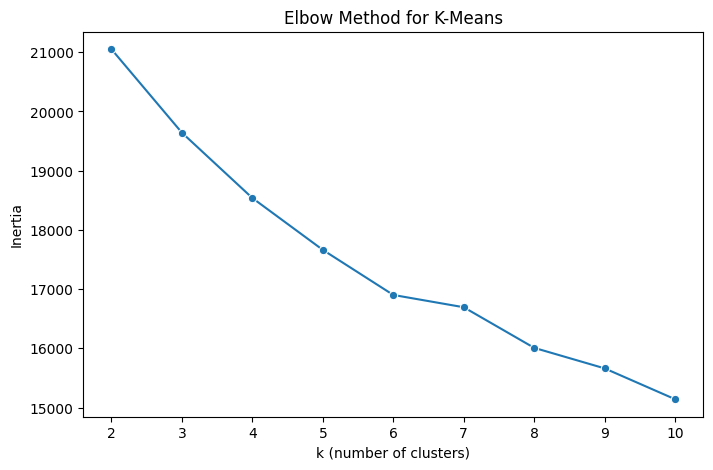

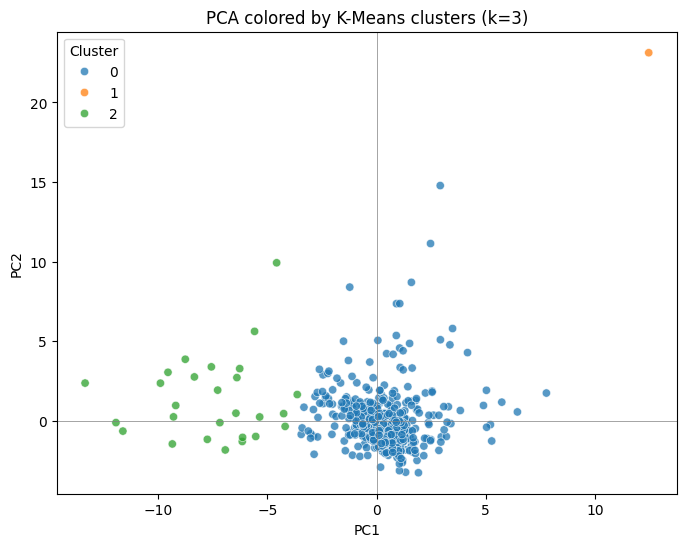

In [ ]:
# Elbow method for K-Means and clustering visualization
k_range = range(2, 11)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.xticks(list(k_range))
plt.show()

# Choose k after inspecting the elbow; adjust if needed
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

# Attach cluster labels
pca_df["Cluster"] = clusters

df_final_cluster = df_final.copy()
df_final_cluster["Cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.75)
plt.title(f"PCA colored by K-Means clusters (k={chosen_k})")
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.legend(title="Cluster")
plt.show()



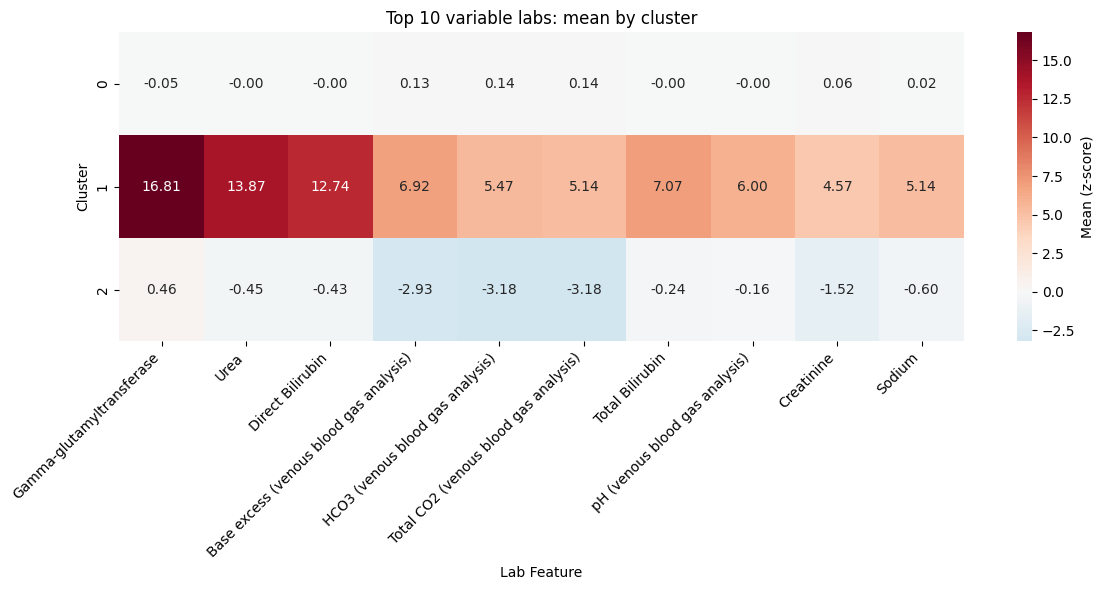

C:\Users\amitf\AppData\Local\Temp\ipykernel_5016\1402659945.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final_cluster, x="Cluster", y=lab, palette="tab10")


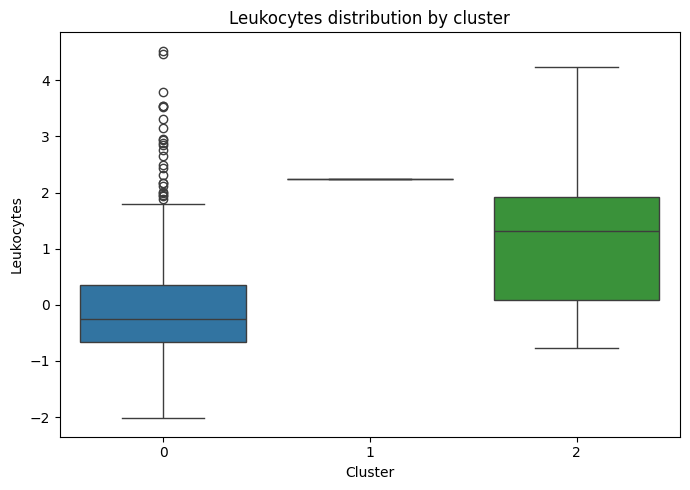

C:\Users\amitf\AppData\Local\Temp\ipykernel_5016\1402659945.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final_cluster, x="Cluster", y=lab, palette="tab10")


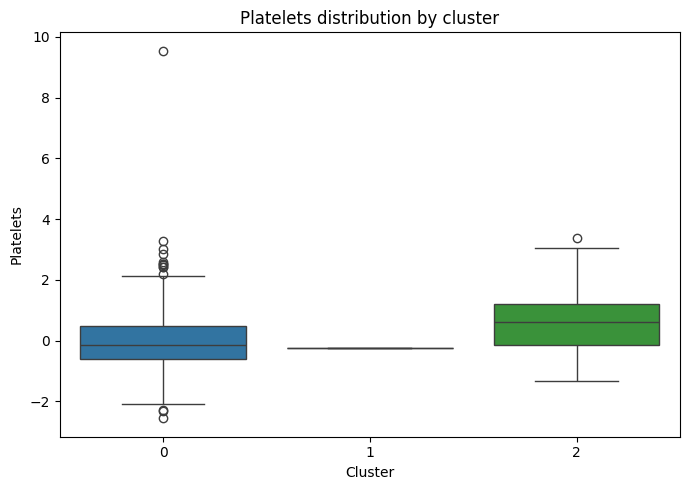

In [ ]:
# Cluster-level heatmap (standardized feature means)
# Heatmap + diagnostics + boxplots
# Define lab features: numeric, excluding ID, SARS result, cluster label
lab_features = [c for c in df_final_cluster.columns
                if (np.issubdtype(df_final_cluster[c].dtype, np.number)
                    and c not in ["Patient ID", "SARS-Cov-2 exam result", "Cluster"])]

if not lab_features:
    print("No numeric lab features found. Dtypes for debugging:")
    print(df_final_cluster.dtypes)
else:
    # Top 10 biomarkers showing strongest between-cluster differences
    cluster_means_full = df_final_cluster.groupby("Cluster")[lab_features].mean()
    top_lab_features = (cluster_means_full.std(axis=0)
                        .sort_values(ascending=False)
                        .head(10)
                        .index.tolist())

    cluster_means = cluster_means_full[top_lab_features]

    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means, cmap="RdBu_r", center=0, annot=True, fmt=".2f",
                cbar_kws={"label": "Mean (z-score)"})
    plt.title("Top 10 variable labs: mean by cluster")
    plt.ylabel("Cluster")
    plt.xlabel("Lab Feature")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Boxplots for selected labs
    for lab in ["Leukocytes", "Platelets"]:
        if lab in df_final_cluster.columns:
            plt.figure(figsize=(7, 5))
            sns.boxplot(data=df_final_cluster, x="Cluster", y=lab, palette="tab10")
            plt.title(f"{lab} distribution by cluster")
            plt.xlabel("Cluster")
            plt.ylabel(lab)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Lab not found for boxplot: {lab}")



In [ ]:
from scipy.stats import f_oneway, chi2_contingency

# Ensure clustering dataframe exists
if 'df_final_cluster' not in globals() or 'Cluster' not in df_final_cluster.columns:
    raise RuntimeError("df_final_cluster with 'Cluster' column not found. Please run preprocessing/PCA/KMeans cells first.")

# Top distinguishing continuous biomarkers (adjust if missing)
top_biomarkers = [
    'Proteina C reativa mg/dL',
    'Leukocytes',
    'Platelets',
    'Creatinine',
    'Urea',
]

results = []
for feat in top_biomarkers:
    if feat not in df_final_cluster.columns:
        print(f"Skipping missing feature: {feat}")
        continue
    # Ensure numeric
    vals = df_final_cluster[feat].apply(pd.to_numeric, errors='coerce')
    df_feat = pd.DataFrame({'Cluster': df_final_cluster['Cluster'], 'val': vals}).dropna()
    groups = [df_feat.loc[df_feat['Cluster'] == c, 'val'] for c in sorted(df_feat['Cluster'].unique())]
    # Require data in all clusters
    if any(len(g) == 0 for g in groups):
        print(f"Skipping {feat}: empty group")
        continue
    f_stat, p_val = f_oneway(*groups)
    cluster_means = df_feat.groupby('Cluster')['val'].mean()
    results.append({
        'Feature': feat,
        'Cluster 0 Mean': cluster_means.get(0, float('nan')),
        'Cluster 1 Mean': cluster_means.get(1, float('nan')),
        'Cluster 2 Mean': cluster_means.get(2, float('nan')),
        'p_value': p_val,
        'F_stat': f_stat,
    })

# Evidence table
if results:
    evidence_df = pd.DataFrame(results)
    evidence_df['p_value_fmt'] = evidence_df['p_value'].apply(lambda p: '< 0.001' if p < 1e-3 else f"{p:.3f}")
    evidence_df['Significance'] = evidence_df['p_value'].apply(lambda p: '*' if p < 0.05 else '')
    evidence_df = evidence_df[[
        'Feature', 'Cluster 0 Mean', 'Cluster 1 Mean', 'Cluster 2 Mean', 'p_value_fmt', 'Significance'
    ]].sort_values(by='p_value_fmt')
    print("One-way ANOVA (top biomarkers):")
    display(evidence_df)
else:
    print("No ANOVA results computed. Check feature availability.")

# Chi-square for ICU admission
icu_col = 'Patient addmited to intensive care unit (1=yes, 0=no)'
if icu_col in df_final_cluster.columns:
    contingency = pd.crosstab(df_final_cluster['Cluster'], df_final_cluster[icu_col].fillna(0).astype(int))
    chi2, chi_p, _, _ = chi2_contingency(contingency)
    print(f"Chi-square p-value for Cluster vs ICU: {chi_p:.4g}")
    display(contingency)
else:
    print(f"ICU column not found: {icu_col}")



One-way ANOVA (top biomarkers):


,Feature,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,p_value_fmt,Significance
0,Proteina C reativa mg/dL,-0.029149,2.137217,0.541601,0.001,*
2,Platelets,-0.030778,-0.241048,0.664375,0.002,*
1,Leukocytes,-0.060292,2.233926,1.201259,< 0.001,*
3,Creatinine,0.063287,4.571409,-1.517085,< 0.001,*
4,Urea,-0.002845,13.872796,-0.453214,< 0.001,*


Chi-square p-value for Cluster vs ICU: 2.134e-13


"Patient addmited to intensive care unit (1=yes, 0=no)",0,4
Cluster,,
0,555,20
1,0,1
2,19,8
